In [2]:
# Main imports
from econml.ortho_forest import DMLOrthoForest, DROrthoForest
from econml.causal_forest import CausalForest
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
import matplotlib.pyplot as plt

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\econml\causal_forest.py:74: FutureWarning: This class will be removed from a future version of this package; please use econml.sklearn_extensions.linear_model.WeightedLassoCV instead.
  model_Y=LassoCVWrapper(cv=3),


In [1]:
# Treatment effect function
def exp_te(x):
    return np.exp(2*x[:, 0])
# DGP constants
np.random.seed(123)
n = 20000
n_w = 3
support_size = 3
n_x = 1
# Outcome support
support_Y = np.random.choice(range(n_w), size=support_size, replace=False)
coefs_Y = np.random.uniform(0, 1, size=support_size)
epsilon_sample = lambda n: np.random.uniform(-1, 1, size=n)
# Treatment support 
support_T = support_Y
coefs_T = np.random.uniform(0, 1, size=support_size)
eta_sample = lambda n: np.random.uniform(-1, 1, size=n) 

# Generate controls, covariates, treatments and outcomes
W = np.random.normal(0, 1, size=(n, n_w))
X = np.random.uniform(0, 1, size=(n, n_x))
# Heterogeneous treatment effects
true_te = exp_te
TE = true_te(X)
T = np.dot(W[:, support_T], coefs_T) + eta_sample(n)
y = TE * T + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)
X = np.hstack([X, W])
n_x = n_x + n_w
y = y.reshape(-1, 1)
T = T.reshape(-1, 1)

# ORF parameters and test data
subsample_ratio = 0.3
lambda_reg = np.sqrt(np.log(n_w) / (10 * subsample_ratio * n))
X_test = X[:1000].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), 1000)

In [30]:
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LassoCV, Lasso, MultiTaskLassoCV
cv = KFold(n_splits=5, shuffle=True)
cv = list(cv.split(X))
y = y - cross_val_predict(LassoCV(), X, y, cv=cv).reshape(y.shape)
T = T - cross_val_predict(LassoCV(), X, T, cv=cv).reshape(T.shape)

In [221]:
import numpy as np
import scipy.special
np.random.seed(123)
n_samples = 1000
n_features = 100
n_treatments = 3
n_outputs = 1
# true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
                               np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
X = np.random.normal(0, 1, size=(n_samples, n_features))
X = np.random.normal(0, 1, size=(n_samples, n_features))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] = np.random.binomial(1, scipy.special.expit(X[:, 0]))
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + X[:, [0]]
X_test = X[:1000].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), 1000)

In [220]:
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LassoCV, Lasso, MultiTaskLassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
cv = KFold(n_splits=2, shuffle=True)
cv = list(cv.split(X))
for t in range(y.shape[1]):
    y[:, t] = y[:, t] - cross_val_predict(LassoCV(), X, y[:, t], cv=cv)
for t in range(T.shape[1]):
    T[:, t] = T[:, t] - cross_val_predict(RandomForestClassifier(min_samples_leaf=40), X, T[:, t],
                                          cv=cv, method='predict_proba')[:, 1]

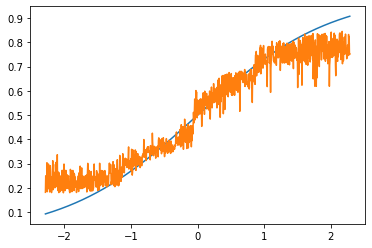

In [53]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

plt.plot(X_test[:, 0], scipy.special.expit(X_test[:, 0]))
plt.plot(X_test[:, 0], RandomForestClassifier(n_estimators=100, 
                                              min_samples_leaf=100).fit(X, T[:, 0]).predict_proba(X_test)[:, 1])
plt.show()

# Ensemble Estimator fit

In [222]:
from econml.tree import Tree
from econml.grf import LinearMomentGRFCriterionMSE, LinearMomentGRFCriterion
from econml.tree import BestSplitter
from econml.tree import DepthFirstTreeBuilder
from sklearn.model_selection import train_test_split
import numpy as np


def fit(X, y, n_features, n_outputs, random_state, 
        criterion='het',
        max_depth = 100,
        min_samples_leaf = 100,
        min_balancedness_tol = .3,
        min_impurity_decrease=-np.inf, 
        subsample_fr=.7, replace=False, 
        honest=True):
    min_samples_split = 2
    min_weight_leaf = 0
    max_features = n_features
    n_outputs = n_outputs
    n_samples = X.shape[0]

    random_state = np.random.RandomState(random_state)
    inds = random_state.choice(X.shape[0], int(np.ceil(subsample_fr * X.shape[0])), replace=replace)
    sample_weight = np.zeros(X.shape[0])
    sample_weight[inds] = 1

    if honest:
        Xtrain, Xval, ytrain, yval,\
            sample_weight_train, sample_weight_val, inds_train, inds_val = train_test_split(X, y, sample_weight,
                                                                                            np.arange(X.shape[0]),
                                                                                            train_size=.5,
                                                                                            random_state=random_state)
    else:
        Xtrain, Xval, ytrain, yval,\
            sample_weight_train, sample_weight_val, inds_train, inds_val = X, X, y, y, sample_weight, sample_weight,\
            np.arange(X.shape[0]), np.arange(X.shape[0])
    tree = Tree(n_features, n_outputs, store_jac=True)
    if criterion == 'het':
        criterion = LinearMomentGRFCriterion(n_outputs, n_features, Xtrain.shape[0], Xval.shape[0])
    else:
        criterion = LinearMomentGRFCriterionMSE(n_outputs, n_features, Xtrain.shape[0], Xval.shape[0])
    splitter = BestSplitter(criterion, max_features, min_samples_leaf, min_weight_leaf,
                            min_balancedness_tol, random_state)
    builder = DepthFirstTreeBuilder(splitter, min_samples_split, min_samples_leaf, min_weight_leaf,
                                    max_depth, min_impurity_decrease)
    builder.build(tree, Xtrain, ytrain, Xval, yval, n_features,
                  sample_weight=sample_weight_train, sample_weight_val=sample_weight_val, store_jac=True)
    if honest:
        sample_weight[inds_train] = 0
    return tree, sample_weight

# Comparison with RF running time

In [181]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=1, min_samples_leaf=20, n_jobs=-1, verbose=1).fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


# Fitting without Honesty

In [223]:
from econml.utilities import cross_product
from joblib.parallel import Parallel, delayed
import warnings
warnings.simplefilter('ignore')

Taug = np.hstack([T, np.ones((T.shape[0], 1))])
n_features = X.shape[1]
n_outputs = Taug.shape[1]
alpha = y * Taug
pointJ = cross_product(Taug, Taug)
Data = np.asfortranarray(np.hstack([X, alpha, pointJ]))
random_state = np.random.RandomState(123)
forest = Parallel(n_jobs=-1, backend='threading', verbose=1)(
                    delayed(fit)(Data[:Data.shape[0]//2], y[:Data.shape[0]//2], n_features, n_outputs,
                                 random_state.randint(np.iinfo(np.int32).max),
                                 criterion='het',
                                 max_depth = 100,
                                 min_samples_leaf = 20,
                                 min_balancedness_tol = .3,
                                 min_impurity_decrease=-np.inf,
                                 subsample_fr=.9, replace=False, honest=False) for _ in range(1000))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    7.6s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


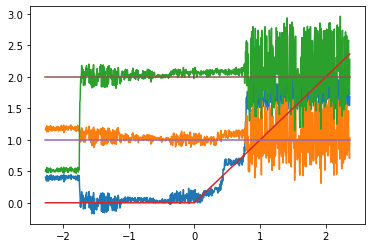

In [224]:
import matplotlib.pyplot as plt
plt.plot(X_test[:, 0],
         np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(delayed(tree.predict)(X_test)
                 for tree, _ in forest), axis=0)[:, :-1])
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


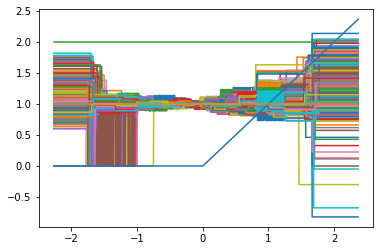

In [199]:
import matplotlib.pyplot as plt
plt.plot(X_test[:, 0],
         np.array(Parallel(n_jobs=-1, backend='threading', verbose=1)(delayed(tree.predict)(X_test)
                 for tree, _ in forest))[:, :, 1].T)
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()

# Fitting with honesty

In [225]:
from econml.utilities import cross_product
from joblib.parallel import Parallel, delayed
import warnings
warnings.simplefilter('ignore')

Taug = np.hstack([T, np.ones((T.shape[0], 1))])
n_features = X.shape[1]
n_outputs = Taug.shape[1]
alpha = y * Taug
pointJ = cross_product(Taug, Taug)
Data = np.asfortranarray(np.hstack([X, alpha, pointJ]))
random_state = np.random.RandomState(123)
forest = Parallel(n_jobs=-1, backend='threading', verbose=1)(
                    delayed(fit)(Data, y, n_features, n_outputs,
                                 random_state.randint(np.iinfo(np.int32).max),
                                 criterion='mse',
                                 max_depth = 100,
                                 min_samples_leaf = 20,
                                 min_balancedness_tol = .3,
                                 min_impurity_decrease = 0,
                                 subsample_fr=.9, replace=False, honest=True) for _ in range(1000))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   11.0s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


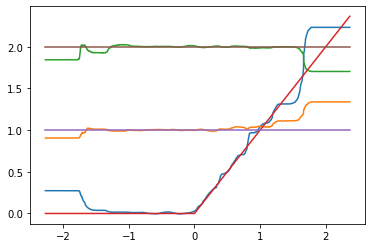

In [226]:
import matplotlib.pyplot as plt
pred_test_point = np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(delayed(tree.predict)(X_test)
                                                                              for tree, _ in forest), axis=0)
plt.plot(X_test[:, 0], pred_test_point[:, :-1])
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()

In [227]:
np.unique(np.concatenate([tree.feature for tree, _ in forest]), return_counts=True)

(array([-2,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
        50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
        67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
        84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
       dtype=int64),
 array([16399, 14921,     4,     1,     9,     4,     6,     5,     1,
            4,     3,     5,     4,     3,     8,     2,    21,     3,
            3,     2,     9,     5,     1,     3,     4,     9,     6,
            8,     5,     3,     2,     4,     4,     5,     6,     3,
           11,     5,    11,     8,     3,     3,     2,     7,     8,
            4,     7,     5,    15,     6,     4,     2,     6,     4,
            5,     9,     7,     7,     3,    10,     5,     4,     1,
            8,     5,     2, 

In [228]:
np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(tree.compute_feature_importances)(normalize=True) for tree, _ in forest), axis=0)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


array([9.96832068e-01, 1.46213302e-05, 3.47277087e-05, 3.28345428e-05,
       8.39979705e-06, 3.67014897e-05, 2.84008041e-05, 1.71704746e-06,
       8.78460386e-06, 1.13155698e-05, 2.76024823e-05, 3.95410159e-05,
       2.63945989e-05, 5.39647404e-05, 7.46513334e-06, 1.81881585e-04,
       1.22597670e-05, 2.39400606e-05, 2.08632512e-06, 7.40606691e-05,
       3.44207564e-05, 1.36381379e-05, 1.70992681e-05, 2.03562708e-05,
       4.39684060e-05, 2.78611936e-05, 6.92714708e-05, 1.79093501e-05,
       1.84410579e-05, 6.83381053e-06, 1.20779622e-05, 3.21909943e-05,
       8.43229920e-06, 3.35343985e-05, 3.69685756e-05, 7.67942098e-05,
       2.92834868e-05, 8.19670098e-05, 1.10936667e-04, 2.66237542e-05,
       4.37925058e-06, 2.65886140e-05, 4.84691817e-05, 2.34601955e-05,
       2.49702094e-05, 2.01767033e-05, 6.61855826e-06, 9.70738601e-05,
       4.50248582e-05, 3.12337517e-05, 1.84139070e-06, 4.61746705e-05,
       3.47217696e-06, 1.94337717e-05, 6.80841248e-05, 5.13628879e-05,
      

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


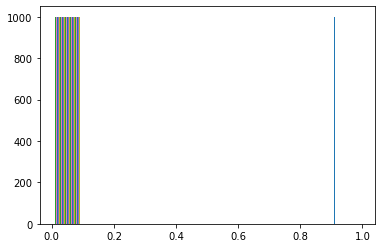

In [194]:
plt.hist(np.array(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(tree.compute_feature_importances)(normalize=True) for tree, _ in forest)))
plt.show()

In [195]:
forest[0][0].impurity[:10]

array([4.57879474, 3.25593652, 2.08901298, 0.97709833, 0.50697443,
       0.25781293, 0.1535197 , 1.4728142 , 0.91165182, 0.45307312])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


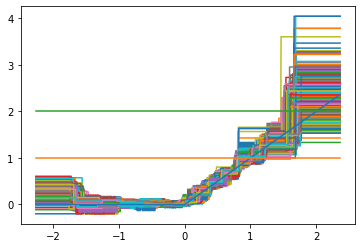

In [235]:
import matplotlib.pyplot as plt
plt.plot(X_test[:, 0],
         np.array(Parallel(n_jobs=-1, backend='threading', verbose=1)(delayed(tree.predict)(X_test)
                 for tree, _ in forest))[:, :, 0].T)
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()

### Inverse of average Jacobian instead of average of inverses

In [230]:
alpha_test_tree = np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(tree.predict_precond)(X_test) for tree, _ in forest), axis=0)
J_test_tree = np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(tree.predict_jac)(X_test) for tree, _ in forest), axis=0)
pred_test_tree = np.einsum('ijk,ik->ij',
                           np.linalg.pinv(J_test_tree.reshape(-1, alpha_test_tree.shape[1], alpha_test_tree.shape[1])),
                           alpha_test_tree)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


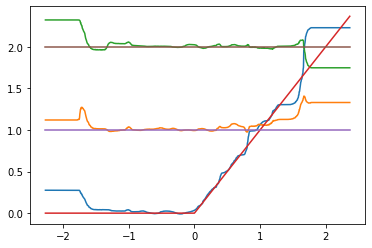

In [231]:
###### import matplotlib.pyplot as plt
plt.plot(X_test[:, 0], pred_test_tree[:, :-1])
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()

In [53]:
def predict(tree, X_test, X_train, alpha_train, pointJ_train, sample_weight_train):
    kernel = tree.apply(X_test).reshape(-1, 1) == tree.apply(X_train).reshape(1, -1)
    kernel = kernel * sample_weight_train.reshape(1, -1)
    kernel_norm = np.sum(kernel, axis=1, keepdims=True)
    alpha_test = kernel @ alpha_train / kernel_norm
    J_test = kernel @ pointJ / kernel_norm
    return np.hstack([alpha_test, J_test])

alphaJ_test = np.mean(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(predict)(tree, X_test, X, alpha, pointJ, sample_weight)
                 for tree, sample_weight in forest), axis=0)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   17.4s finished


In [54]:
alpha_test, J_test = alphaJ_test[:, :alpha.shape[1]], alphaJ_test[:, alpha.shape[1]:]
pred_test = np.einsum('ijk,ik->ij', np.linalg.pinv(J_test.reshape(-1, alpha.shape[1], alpha.shape[1])), alpha_test)

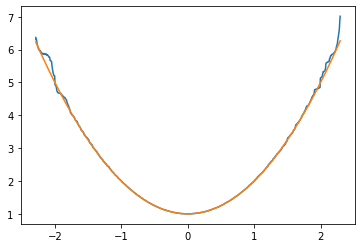

In [55]:
import matplotlib.pyplot as plt
plt.plot(X_test[:, 0], pred_test[:, :-1])
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()

In [56]:
np.testing.assert_almost_equal(alpha_test, alpha_test_tree)
np.testing.assert_almost_equal(J_test, J_test_tree)
np.testing.assert_almost_equal(pred_test, pred_test_tree)

### Feature importances

In [218]:
np.nanmean(Parallel(n_jobs=-1, backend='threading', verbose=1)(
    delayed(tree.compute_feature_importances)(normalize=True) for tree, _ in forest), axis=0)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


array([9.98223409e-01, 6.85408182e-07, 7.00116092e-07, 7.78915070e-07,
       3.49122607e-05, 1.53789062e-05, 1.67572519e-05, 4.69840980e-06,
       1.82065200e-05, 1.77847468e-05, 1.61339835e-05, 3.66759866e-05,
       1.74374990e-05, 1.54146603e-05, 1.33285957e-05, 1.97225210e-05,
       5.05053693e-05, 8.77069478e-07, 8.41519020e-06, 6.42988979e-05,
       1.15164075e-05, 1.52183706e-06, 2.20779713e-06, 1.27550948e-05,
       5.54203230e-05, 2.05451764e-05, 2.25176045e-05, 1.55702011e-05,
       4.44104044e-06, 9.79450354e-06, 5.28004721e-06, 9.54620494e-06,
       4.47517892e-05, 1.57918576e-05, 4.55785277e-06, 1.56404104e-06,
       4.91508973e-06, 1.83119070e-05, 2.65342821e-06, 1.76037318e-05,
       4.49679922e-06, 7.78986911e-05, 1.37505160e-06, 2.04490800e-05,
       7.21598205e-05, 9.90310013e-06, 1.40925051e-05, 4.45337018e-05,
       9.14046858e-06, 1.15092879e-05, 2.92001012e-05, 2.14584670e-05,
       1.14095530e-04, 8.27593847e-06, 1.30488031e-05, 1.12051768e-06,
      

# Comparison with ORF and Current Causal Forest

In [90]:
from econml.dml import ForestDML
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor
est = ForestDML(model_y=RandomForestRegressor(min_samples_leaf=100),
                model_t=RandomForestRegressor(min_samples_leaf=100),
                n_estimators=1000, min_samples_leaf=20, subsample_fr=.9,
                max_depth=100, verbose=0, n_jobs=-1).fit(y, T, X=X)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    6.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Paral

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]

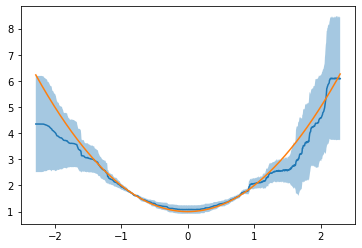

In [91]:
import matplotlib.pyplot as plt
plt.plot(X_test[:, 0], est.const_marginal_effect(X_test)[:, 0, 0])
plt.fill_between(X_test[:, 0],
                 *map(lambda x: x[:, 0, 0], est.const_marginal_effect_interval(X_test, alpha=0.01)), alpha=.4)
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()

In [137]:
from econml.causal_forest import CausalForest
from sklearn.linear_model import Lasso, MultiTaskLasso
from econml.sklearn_extensions.linear_model import WeightedLasso, WeightedMultiTaskLasso

est = CausalForest(n_trees=100, subsample_ratio=.9, min_leaf_size=20,
                   max_depth=100, model_T=WeightedMultiTaskLasso(), model_Y=WeightedLasso()).fit(y, T, X=X)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.2s finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 498 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   10.7s finished


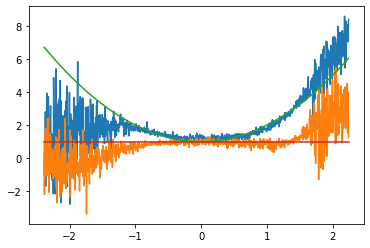

In [138]:
import matplotlib.pyplot as plt
plt.plot(X_test[:, 0], est.const_marginal_effect(X_test)[:, 0])
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()

In [ ]:
from econml.ortho_forest import DMLOrthoForest
from sklearn.linear_model import Lasso, MultiTaskLasso
from econml.sklearn_extensions.linear_model import WeightedLasso, WeightedMultiTaskLasso

est = DMLOrthoForest(n_trees=100, subsample_ratio=.9, min_leaf_size=20,
                     max_depth=100, model_T=WeightedMultiTaskLasso(), model_Y=WeightedLasso()).fit(y, T, X=X)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min


In [ ]:
import matplotlib.pyplot as plt
plt.plot(X_test[:, 0], est.const_marginal_effect(X_test)[:, 0])
plt.plot(X_test[:, 0], true_te(X_test))
plt.show()